## Data Cleaning, EDA and Pre-processing

In [1]:
import numpy as np
import pandas as pd  
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import contractions
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords, words
import re
import emoji
import pickle as pk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.svm import SVC
import statistics
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models.phrases import Phrases, Phraser 
import gensim.downloader as api
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
cf2 = pd.read_csv('../data/crossfit_subs2.csv')
bjj2 = pd.read_csv('../data/bjj_subs2.csv')

In [4]:
# Number of submissions scraped from each subreddit

print(len(cf2), 'submissions scraped from r/crossfit')
print(len(bjj2), 'submissions scraped from r/bjj')

1482 submissions scraped from r/crossfit
1630 submissions scraped from r/bjj


In [5]:
# Combining into a single dataset

df = pd.concat([cf2, bjj2], axis = 0)
df

,Unnamed: 0,0,type,label
0,0,"Hi guys, just needing a bit of an unbiased advise. I’ll try and keep this in dot point format and straight to the point. \n\nBackground:\n- Male - 28 year old - training roughly 5x a week every year for the past 3-4 years \n- 100kg, 46kg muscle mass, 20% body fat. \n- strength is no issue at all, but conditioning is a problem. Both cardio and muscular endurance suck. \n- I train in a bootcamp style class/environment using mostly bootcamp equipment - I.e no bars/rigs, rings, ropes, heavy weights (floors are wooden) \n- Although it’s a bootcamp, the programs are still influenced by CrossFit styled workouts as the coaches are CrossFit athletes\n- Workouts are usually 30-40 min TABATA, AMRAPS and partnered WODs with 2x strength components in the week. Workouts are really taxing (about 8-10 RPE)\n- last 2 years I’ve also been doing 2x additional program days in the gym programmed by the coach of the bootcamp. This is so that I can do more CrossFit-style training with the equipment, particularly to build my conditioning. \n\nIssue:\n- starting to become demotivated as the opens and recent local comps have really made me realise just how far I am from where I’d like to be (at least making quarters). Currently in the 70-80 percentile. \n- for the amount of training I do, and the intensity I train at, I feel a little disheartened by the fact that I am getting similar scores to other people at bootcamp who don’t really put the extra time and work in and are a lot more ‘relaxed’ and uninvested in training. \n- my skills are there (muscle ups, HS walks, HSPU etc) but my engine is not there. \n\nAdvice:\nI’m trying to build my engine and I just can’t seem to improve it over the years. I’m not sure what I’m doing wrong. \nI’ve trialed programs like underdogs athlete, HWPO, PRVN etc and genuinely love them, they incorporate the conditioning pieces like Zone 2 and row intervals. I’ve really stuck with Underdogs. However I can’t commit to this AND bootcamp as I also work full time. \nI’m also looking at joining a CrossFit box to attend maybe once a week just to be amongst a group (I work ok on my own, and the programs allow me to spend 2-3 hours at a CrossFit gym). \n\nQuestion:\n1) am I missing anything? Any reason why I can’t seem to get ‘fitter’ despite the intensity I train at and the consistency of it? \n2) should I join CrossFit classes at a local box or should I stick with the Underdogs program? \n3) I’m extremely loyal to the bootcamp as I’ve been there a long time and am close to the coaches. But are my goals unrealistic here? \n\nThanks for your support guys!",submissions,crossfit
1,1,But I do workout and have stopped. I found out I have a torn labrum. Has anyone had this and continued to workout? Did you have surgery? I’ve seen an orthopedic and had a steroid injection but it only relieves it temporarily.,submissions,crossfit
2,2,"Hi everyone,\n\nJust curious if anyone has ever dealt with the aforementioned and how you managed to recover?\n\nMy initial injury happened about a year and a half ago. Took a lot of time off training, and basically went the meds (pain management?) route. It worked, and I was back to training after a few months. Never really did any exercises to strengthen my core/lower back and stabilising muscles. Just relied on meds (my bad). \n\nFFW to about 4 months ago. Started as a niggle, went into full blown agony and wasn’t even able to pick up my baby from his playmat or crib. \n\nI’ve attended 2 physio sessions and have been taking pain meds (disclaimer: I have a history with addiction and an intense dislike for any form of pill since being in recovery). However, the meds have helped me regain a lot of ROM and mitigated the pain a lot. Haven’t trained in over 3 weeks and although there is improvement I’m still in a bit of dark place due to not training and still being in pain (every so often I lapse in pain, iow, take a few steps back again). \n\nI am doing the movements to help th

In [6]:
# Dropping unnecessary columns and renaming them

df.drop(["Unnamed: 0", "type"], inplace = True, axis = 1)
df.rename({"0" : "posts"}, inplace = True, axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 0 to 1629
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   posts   3110 non-null   object
 1   label   3112 non-null   object
dtypes: object(2)
memory usage: 72.9+ KB


In [8]:
df.describe()

,posts,label
count,3110,3112
unique,3107,2
top,[removed],bjj
freq,2,1630


In [9]:
df.tail()

,posts,label
1625,"Traveling for a conference and exploring options to go for some causal rolling. \nWhite belt, about a year in training.",bjj
1626,"Hello reddit,\n\nSome time ago I asked for the best instructionals for mount attacks and you gave me amazing suggestions thay have made my mount game so much better in no time. Now I feel that my offense is getting a lot better, but since I got my blue belt people have less mercy of me so defense, specially my scapes from side mount and full mount have stopped working for the most part. I really want to start putting time on the mats and off the mats practicing and studying pin scapes, so I hereby ask you again.\n\nWhich are in your oppinion the best pin scapes instructionals and why?\n\nThanks a lot!!",bjj
1627,"I will be staying downtown (new east side) and want to check out classes there, preferably no-gi. Also want to explore gyms that rank high in comp locally but don’t know how to find the record of ranking….",bjj
1628,"Hello everyone. Anyone have any input on good BJJ gyms in Essex, UK?",bjj
1629,"I got a staph infection on my right posterior thigh about 3 months ago. Go antibiotics, got it cleared up using betadine and bandaging. About 3 weeks ago I got another right below my right knee on the lateral aspect of my leg. Did the same thing, got it drained, got bacterum and used betadine and bandaging til it cleared up. I went to Jiu Jitsu last night and tonight and now I have another spot on my right knee that is tender, red and swollen. I’ve started wearing tights under my shorts to prevent bacteria getting on my skin more. I’m just upset and wondering what I can do for a solution. I missed my blue belt promotion because of my second infection. I feel like I’m missing out on so much training. I shower as soon as I get home from my 10 minute commute from Jiu Jitsu, I immediately wash my clothes. Any advice? I’m going to urgent care again tomorrow to get it looked at, so wish me luck. Thanks",bjj


### 1. Prelimary EDA

In [10]:
df.isna().sum()

posts    2
label    0
dtype: int64

In [11]:
# Removing rows with missing data

df.dropna(inplace = True)
len(df)

3110

In [12]:
# Total number of words in the corpus

total_words = 0

for text in df['posts']:
    words = text.split()
    total_words += len(words)
print(total_words)

279918


90.00578778135048


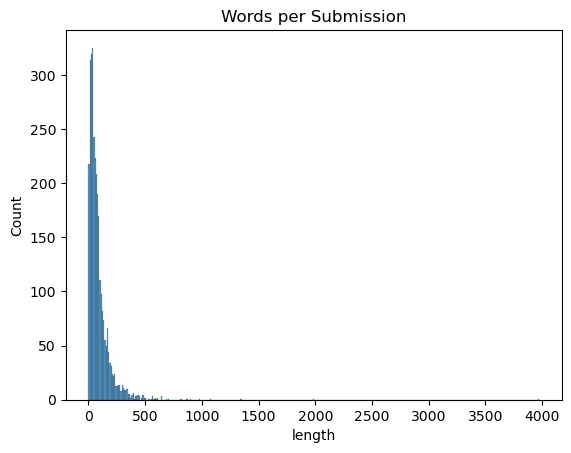

In [13]:
# Length of each submission

df["length"] = df["posts"].apply(lambda x : len(x.split()))
sns.histplot(df["length"]).set(title='Words per Submission')
print(df["length"].mean())

[Text(0.5, 1.0, 'Characters per Submission')]

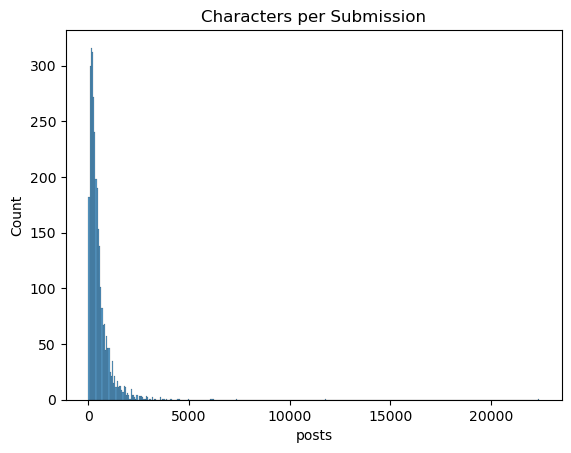

In [14]:
# Looking at number of characters present in each submission

sns.histplot(df["posts"].str.len()).set(title='Characters per Submission')


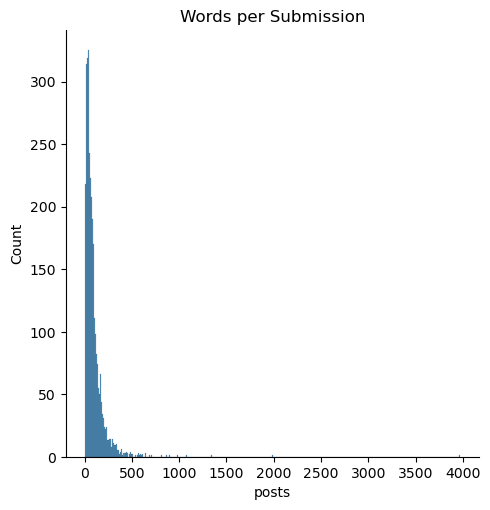

In [15]:
# Number of words per submission

sns.displot(df["posts"].str.split().map(lambda x: len(x))).set(title='Words per Submission')


Most submissions are relatively short and contain fewer than 500 words. 

In [16]:
# Splitting the corpus into the 2 topics

crossfit_posts = df[df["label"] == "crossfit"]
bjj_posts = df[df["label"] == "bjj"]

In [17]:
# Finding the most common stopwords for crossfit

stopwords_nltk = stopwords.words('english')

corpus_cf = []
subs = crossfit_posts["posts"].str.split()
subs = subs.values.tolist()
corpus_cf = [word for i in subs for word in i]

dic = defaultdict(int)

for word in corpus_cf:
    if word in stopwords_nltk:
        dic[word]+=1

Text(0.5, 1.0, 'Top Stopwords for Crossfit')

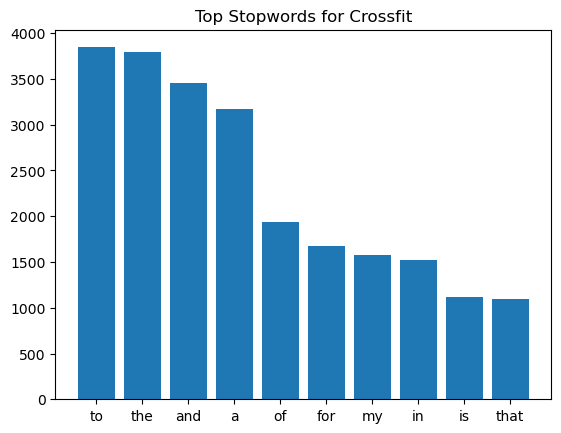

In [18]:
# Visualising the results

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y = zip(*top)
plt.bar(x, y)
plt.title("Top Stopwords for Crossfit")

Frequent stopwords are quite an expected list, and will be removed subsequently during data cleaning.

In [19]:
# Finding the most common stopwords for BJJ

stopwords_nltk = stopwords.words('english')

corpus_bjj = []
subs = bjj_posts["posts"].str.split()
subs = subs.values.tolist()
corpus_bjj = [word for i in subs for word in i]

dic = defaultdict(int)
for word in corpus_bjj:
    if word in stopwords_nltk:
        dic[word]+=1

Text(0.5, 1.0, 'Top Stopwords for BJJ')

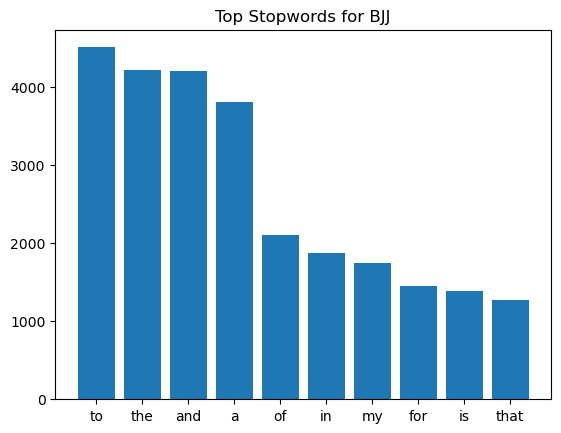

In [20]:
# Visualising the results

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y = zip(*top)
plt.bar(x,y)
plt.title("Top Stopwords for BJJ")

These are words that are not likely to add to the model's ability to classify between the two topics, as they have a high frequency of occurrence in both datasets. We'll have to remove them later on to improve the model's predictive ability. 

[Text(0.5, 1.0, 'Top words for Crossfit that are not stopwords')]

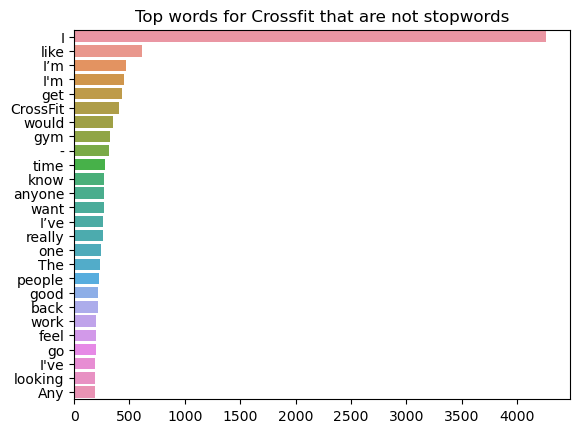

In [21]:
# Which are the most common words for Crossfit that are not in the default stopword list?

counter = Counter(corpus_cf)
most = counter.most_common()

x, y= [], []

for word,count in most[:80]:
    if (word not in stopwords_nltk):
        x.append(word)
        y.append(count)

sns.barplot(x = y,y = x).set(title = 'Top words for Crossfit that are not stopwords')


[Text(0.5, 1.0, 'Top words for BJJ that are not stopwords')]

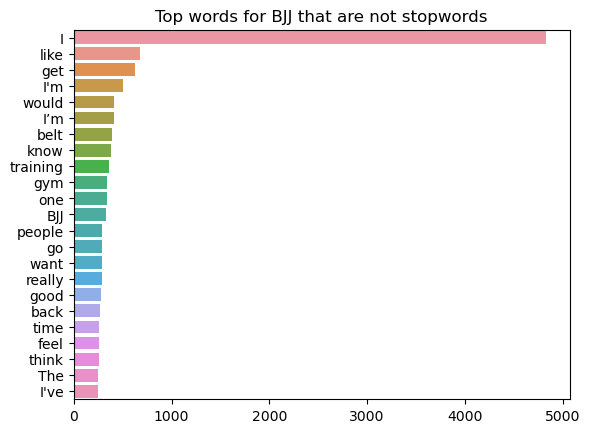

In [22]:
# Which are the most common words for BJJ that are not in the default stopword list?

counter = Counter(corpus_bjj)
most = counter.most_common()

x, y = [], []
for word,count in most[:80]:
    if (word not in stopwords_nltk):
        x.append(word)
        y.append(count)

sns.barplot(x = y,y = x).set(title = 'Top words for BJJ that are not stopwords')


It is worth noting that the top words not in the NLTK default listing of stopwords still look like they should be excluded from analysis. Some include characters that are not actually words, e.g. '-'. These will be manually removed later during the cleaning stage.

In [23]:
# Taking a look at whether there are duplicates

df[df['posts'].duplicated()]

,posts,label,length
3,[removed],bjj,1
65,[deleted],bjj,1
1246,Thoughts?,bjj,1


There are submission posts that look like they were removed by content moderators, should be removed from analysis.

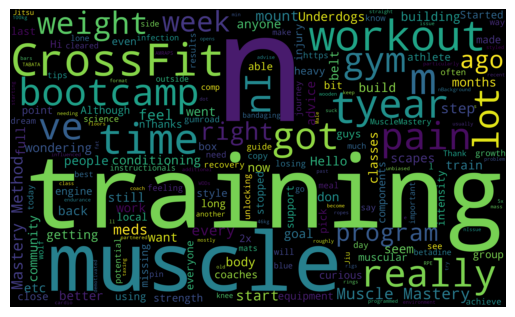

In [24]:
# Creating a word cloud just to see what the corpus looks like without any pre-processing

text = df['posts']

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1000,height=600,background_color='black',scale=4).generate(str(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


There are actually interesting words that are indicative of the subreddit topics, but there are quite a few single letters ("n", and "t") as well as stopwords ("got", "really") that are interfering with other terms that may provide more useful information to differentiate between the 2 topics. Some cleaning and preprocessing could give us better clarity on the content of the reddit submissions and prepare the data for classification modelling.



-----

### 2. Pre-processing and Cleaning


While vectorizers such as CountVectorizer and TFIDF have built-in pre-processing including stopword removal and lowercasing, we will do manual data cleaning for greater control and flexibility. To prep the data for modeling, we did the following: 

- Exclude submissions that were censored by moderators or contain only single symbols 
- Expand contractions (i.e. from "I'm" to "I am")
- Lowercase all text
- Remove keywords that are specific to the topics (i.e. crossfit, brazilian, jiujitsu, etc) since including these terms will make classification much easier and possibly produce a weaker classifier model
- Remove stopwords which are commonly-used words appearing across both subreddits that add noise to the model
- Replace emojis with descriptions of each one. Emojis are retained because they add information to the post relating to the author's emotions.
- Lemmatization to reduce words to their root form while retaining a proper word. This was preferred over stemming which might result in words that are truncated. 
- Remove punctuation, numbers, and "\n" which signify line breaks in the imported text.
- Exclude posts containing fewer than 5 words. This was based off the observation during modeling that submissions comprising a single word are difficult to classify due to limited information. Such short posts could have been accompanied by links or images.

Word clouds and histograms were used to examine the most common words and lengths of words/characters in the document. 

Finally, a quick topic modelling was conducted as part of EDA to get a rough sense of what common themes are associated with these two subreddits to deepen understanding of what the discussions were about.

<br>

In [25]:
# Excluding submissions that were censored, removed by moderators or with only symbols

df = df.drop(df[(df['posts'] == '[removed]') | (df['posts'] == '[deleted]') | (df['posts'] == '.') | (df['posts'] == '?')].index)
df['posts'].value_counts(ascending = False).head()

Thoughts?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [26]:
# Function to clean the dataset 

def preprocess(text):
    
    '''
    This function cleans raw data:
    - expand contractions
    - lowercase 
    - remove links and line breaks
    - remove relevant keywords
    - translate emojis
    - replace HTML
    - remove hashtags and mentions
    
    '''
    
    # Convert contracted text to longer form
    text = contractions.fix(text)

    # Convert to lowercase
    text = text.lower()
    
    # Convert to lowercase
    text = emoji.demojize(text)
    
    # Remove links
    text = re.sub('http://\S+|https://\S+', ' ', text)
    text = re.sub('http[s]?://\S+', ' ', text)
    text = re.sub(r"http\S+|\____+", ' ', text)
    
    # Removing common words used in reddit and line breaks
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\beveryone\b|\bwould\b|\bknow\b|\blook\b|\breally\b|\bthank\w\b|\byou\b|\byes\b|\bit\b|\bget\b|\bgot\b|\bhi\b|\beverybody\b|\banyone\b|\banybody\b|\bwant\b|\bgo\b|\bregard\b|\bone\b|\blike\b|\balso\b|\brealli\b|\bcannot\b', ' ', text)
    
    # Convert HTML references
    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)
    text = re.sub('\d+', ' ', text)

    # Remove mentions
    text = re.sub(r'@\w+', ' ', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', ' ', text)

    # Remove topic-related keywords and their variation
    text = re.sub(r'http\w|www|reddit|\wross\wit|bjj|\wrazilian|\w*ujitsu|jiu\sjitsu\w*|\bjiujitsu\b|\bjiu-jitsu\b',' ', text)

    return text

In [27]:
# applying the preprocessing function

df['preprocessed'] = df['posts'].apply(preprocess)

In [28]:
# Removing stopwords

stopwords_nltk = stopwords.words('english')
df['preprocessed_nosw'] = df['preprocessed'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stopwords_nltk)])
)

In [29]:
# Lemmatizing to reduce words to its root form

lemmatizer = WordNetLemmatizer()

def lemmatised(sentence):
    tokens = sentence.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['lemmatized'] = df['preprocessed_nosw'].apply(lemmatised)

In [30]:
# define function to remove long words

def remove_long_words(text):
    
    # split text into words
    words = text.split()
    
    # only keep words with less than or equal to 15 characters
    words = [w for w in words if len(w) <= 15]
    
    # join remaining words into a string
    return ' '.join(words)

df['lemmatized'] = df['lemmatized'].apply(lambda x: remove_long_words(x))


In [31]:
# Only retaining posts with more than 5 words 
# it's unlikely to contain enough information for classification

df = df.loc[df["lemmatized"].str.count(" ") >= 6]

In [32]:
df.head()

,posts,label,length,preprocessed,preprocessed_nosw,lemmatized
0,"Hi guys, just needing a bit of an unbiased advise. I’ll try and keep this in dot point format and straight to the point. \n\nBackground:\n- Male - 28 year old - training roughly 5x a week every year for the past 3-4 years \n- 100kg, 46kg muscle mass, 20% body fat. \n- strength is no issue at all, but conditioning is a problem. Both cardio and muscular endurance suck. \n- I train in a bootcamp style class/environment using mostly bootcamp equipment - I.e no bars/rigs, rings, ropes, heavy weights (floors are wooden) \n- Although it’s a bootcamp, the programs are still influenced by CrossFit styled workouts as the coaches are CrossFit athletes\n- Workouts are usually 30-40 min TABATA, AMRAPS and partnered WODs with 2x strength components in the week. Workouts are really taxing (about 8-10 RPE)\n- last 2 years I’ve also been doing 2x additional program days in the gym programmed by the coach of the bootcamp. This is so that I can do more CrossFit-style training with the equipment, particularly to build my conditioning. \n\nIssue:\n- starting to become demotivated as the opens and recent local comps have really made me realise just how far I am from where I’d like to be (at least making quarters). Currently in the 70-80 percentile. \n- for the amount of training I do, and the intensity I train at, I feel a little disheartened by the fact that I am getting similar scores to other people at bootcamp who don’t really put the extra time and work in and are a lot more ‘relaxed’ and uninvested in training. \n- my skills are there (muscle ups, HS walks, HSPU etc) but my engine is not there. \n\nAdvice:\nI’m trying to build my engine and I just can’t seem to improve it over the years. I’m not sure what I’m doing wrong. \nI’ve trialed programs like underdogs athlete, HWPO, PRVN etc and genuinely love them, they incorporate the conditioning pieces like Zone 2 and row intervals. I’ve really stuck with Underdogs. However I can’t commit to this AND bootcamp as I also work full time. \nI’m also looking at joining a CrossFit box to attend maybe once a week just to be amongst a group (I work ok on my own, and the programs allow me to spend 2-3 hours at a CrossFit gym). \n\nQuestion:\n1) am I missing anything? Any reason why I can’t seem to get ‘fitter’ despite the intensity I train at and the consistency of it? \n2) should I join CrossFit classes at a local box or should I stick with the Underdogs program? \n3) I’m extremely loyal to the bootcamp as I’ve been there a long time and am close to the coaches. But are my goals unrealistic here? \n\nThanks for your support guys!",crossfit,468,guys just needing a bit of an unbiased advise i will try and keep this in dot point format and straight to the point background male year old training roughly x a week every year for the past years kg kg muscle mass body fat strength is no issue at all but conditioning is a problem both cardio and muscular endurance suck i train in a bootcamp style class environment using mostly bootcamp equipment i e no bars rigs rings ropes heavy weights floors are wooden although is a bootcamp the programs are still influenced by styled workouts as the coaches are athletes workouts are usually min tabata amraps and partnered wods with x strength components in the week workouts are taxing about rpe last years i have been doing x additional program days in the gym programmed by the coach of the bootcamp this is so that i can do more style training with the equipment particularly to build my conditioning issue starting to become demotivated as the opens and recent local comps have made me realise just how far i am from where i to be at least making quarters currently in the percentile for the amount of training i do and the intensity i train at i feel a little disheartened by the fact that i am getting similar scores to other people at bootcamp who do not put the extra time and work in and are a lot more relaxed and u

In [33]:
# Dropping unnecessary columns 

df.drop(columns = ['posts', 'length', 'preprocessed', 'preprocessed_nosw'], inplace = True)

In [102]:
# Random checks

df[df['lemmatized'].str.contains('year ago')]

,label,lemmatized
24,crossfit,used work lot year ago started jan missed day gym every w f id saying pushing pretty hard drink plant based protein shake take pre post workout sup yesterday today starving stomach nonstop cramping eat snack even eat meal stomach still cramping eat year old woman sure related working hoping might able provide insight research internet vast ty
73,crossfit,couple week since taken l wanted drop review issue course first amazing course wish taken year ago training staff accommodating limit actually dialed lot movement think weekend probably squat lol wish people took course even plan coach everything taught use personal life workout awesome glad see hate burpees great warmup accessory tip using medball clean since like program met new friend area big plus issue course pas written test missed lot movement section legals programming issue test worded good way confusion someone studied week leading know material suck order retest person wait offered area forever give option retake online need drop another pas cfl certificate send cfl online certificate even though took l person seems flushed toilet
281,crossfit,hope attempt went well beat previous attempt similar movement volume rep rx year ago able even hanging knee raise well stuck super light wall ball absolutely pumped result fell apart wall ball made jump pd whole experience brilliant seeing athlete gym crush great thing take part
328,crossfit,idea going hylete running massive sale website seem going business level discount previously never seen discount year ago popular brand saw box time recent year noticed much le prevalent perhaps fallen favor community interesting see go need premium gym gear mid tier pricing check website
336,crossfit,love suck terrible genetics body type started year ago still skill always scale everything far weakest getting frustrated thinking quitting health fun feeling bad every time love able local rx competition probably never going happen see point continuing sorry rant share somewhere
...,...,...
1411,bjj,bear started training local gym remote town year ago small bigger guy construction worker diverse athletic background rugby weightlifting etc gym limited upper belt one much smaller take long stop feeling getting smashed dominated say tapping guy ever getting dominated subbed often believe survival period well group experienced people easily dominate crucial feel missing ultimately going reflect development counteract spent past month starting primarily bottom training defence learning basic white belt quality sweep allowing offence earn top position roll reset back bottom understand trade limit development takedown etc make sure still work foot coach bb absolutely wreck sub awesome aware job divide attention amongst player careful new guy trying monopolize time question curate survival based defensive rolling experience tool hand missing year upper belt domination getting subbed ton detrimental benefit work diverse set technique position roll sticking around
1438,bjj,back month ago year mat realize longer desire compete rather day week enjoy time mat used year ago competition often monthly wanted back onto mat back competitive part sport settle gym consistently twice week realizing competitive thirst exist anymore could originally year old working life kind gone past responsibility interest grad school working kind going life using small consistent part week along regularly working kind keep healthy sort social life else moment realizing longer interested way competition asking used regularly competed point
1445,bjj,good morning wanted share experience last year mean inundate sub lame stuff started last november zero clue recently quit drinking smoking wanted outlet new found energy fit bill started anything kept coming class taking lump awkward people talk kept though continued train anywhere time week slowly surely gained ability somewhat defend learned basic move time broke rib crushed cartilage rib well leaving 

In [35]:
# Excluding random posts that are spam

df = df.drop(index=[725, 1614, 1257])

In [36]:
df.head(3)

,label,lemmatized
0,crossfit,guy needing bit unbiased advise try keep dot point format straight point background male year old training roughly x week every year past year kg kg muscle mass body fat strength issue conditioning problem cardio muscular endurance suck train bootcamp style class environment using mostly bootcamp equipment e bar rig ring rope heavy weight floor wooden although bootcamp program still influenced styled workout coach athlete workout usually min tabata amraps partnered wods x strength component week workout taxing rpe last year x additional program day gym programmed coach bootcamp style training equipment particularly build conditioning issue starting become demotivated open recent local comp made realise far least making quarter currently percentile amount training intensity train feel little disheartened fact getting similar score people bootcamp put extra time work lot relaxed uninvested training skill muscle ups h walk hspu etc engine advice trying build engine seem improve year sure wrong trialed program underdog athlete hwpo prvn etc genuinely love incorporate conditioning piece zone row interval stuck underdog however commit bootcamp work full time looking joining box attend maybe week amongst group work ok program allow spend hour gym question missing anything reason seem fitter despite intensity train consistency join class local box stick underdog program extremely loyal bootcamp long time close coach goal unrealistic support guy
1,crossfit,workout stopped found torn labrum continued workout surgery seen orthopedic steroid injection relief temporarily
2,crossfit,curious ever dealt aforementioned managed recover initial injury happened year half ago took lot time training basically went med pain management route worked back training month never exercise strengthen core lower back stabilising muscle relied med bad ffw month ago started niggle went full blown agony even able pick baby playmat crib attended physio session taking pain med disclaimer history addiction intense dislike form pill since recovery however med helped regain lot rom mitigated pain lot trained week although improvement still bit dark place due training still pain every often lapse pain iow take step back movement help disc pressure nerve say helping willing continue long needed moving next step see specialist probably refer mri expensive however even though consider every day feel need patient give time doctor physical therapist agrees concerned extreme symptom yeah advice feeling impending doom pain able pick weight etc laying heavy mind heart chronic pain bitch worm way every single facet thought tia


### 3. Further EDA

In [37]:
# Splitting into the classes

crossfit_clean = df[df['label'] == 'crossfit']
bjj_clean = df[df['label'] == 'bjj']

#### Crossfit top occuring words

In [38]:
# Total number of words in the corpus

total_words = 0

for text in crossfit_clean['lemmatized']:
    words = text.split()
    total_words += len(words)
print(total_words)

58257


42.64787701317716


/var/folders/r9/9246nqp9249ghjl6r9xy_dwr0000gn/T/ipykernel_7665/3726221817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossfit_clean["length"] = crossfit_clean["lemmatized"].apply(lambda x : len(x.split()))


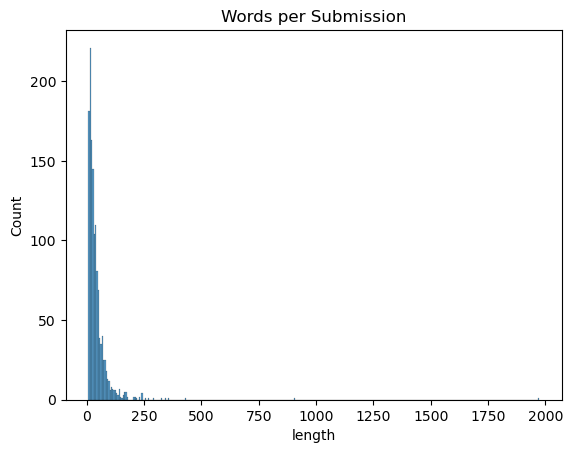

In [39]:
# Length of each submission

crossfit_clean["length"] = crossfit_clean["lemmatized"].apply(lambda x : len(x.split()))
sns.histplot(crossfit_clean["length"]).set(title='Words per Submission')
print(crossfit_clean["length"].mean())

In [40]:
# Counting unigrams

cv = CountVectorizer(ngram_range=(1,1))

In [41]:
# Tokenenising cv = CountVectorizer()

X = cv.fit_transform(crossfit_clean['lemmatized'])
X_df = X.toarray()

In [42]:
# Obtaining the bag of words comprising unigrams, bigrams and trigrams

counts = pd.DataFrame(X_df,
            columns = cv.get_feature_names_out())

In [43]:
# Getting the words 

words = cv.get_feature_names_out()
len(words)

7173

In [44]:
counts2 = counts.T.sort_values(by=0, ascending=False)
counts2['total_count'] = counts2.sum(axis = 1)
counts2.T

,bootcamp,year,program,training,coach,conditioning,time,workout,week,work,...,fittest,fitted,fitr,fitnessing,fitness,fitbod,fitbit,fitaid,fit,zou
0,7,5,5,4,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,3,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,0,0,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Count')

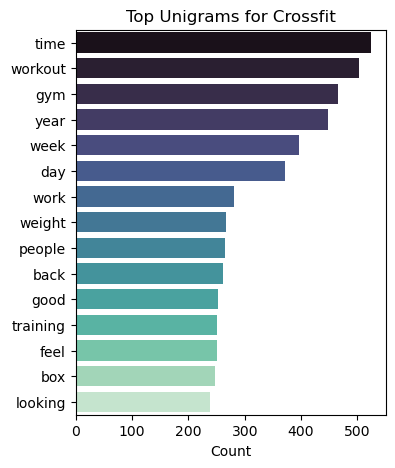

In [45]:
# Looking at the top unigrams by count

counts2[['total_count']].sort_values(by = 'total_count', ascending = False)
top_words = counts2[['total_count']].sort_values(by = 'total_count', ascending = False).head(15)
fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(top_words, y = top_words.index, x = 'total_count', palette="mako").set(title='Top Unigrams for Crossfit')
ax.set_xlabel('Count')

The most commonly occurring words in the corpus relate to exercise and time, which is not too surprising given the topics of the subreddits.

In [46]:
# Counting bigrams

cv = CountVectorizer(ngram_range=(2,2))

In [47]:
# Tokenenising cv = CountVectorizer()

X = cv.fit_transform(crossfit_clean['lemmatized'])
X_df = X.toarray()


In [48]:
# Getting the words 

counts = pd.DataFrame(X_df, columns = cv.get_feature_names_out())
words = cv.get_feature_names_out()

In [49]:
# getting total counts of each 

counts2 = counts.T.sort_values(by=0, ascending=False)
counts2['total_count'] = counts2.sum(axis = 1)

Text(0.5, 0, 'Count')

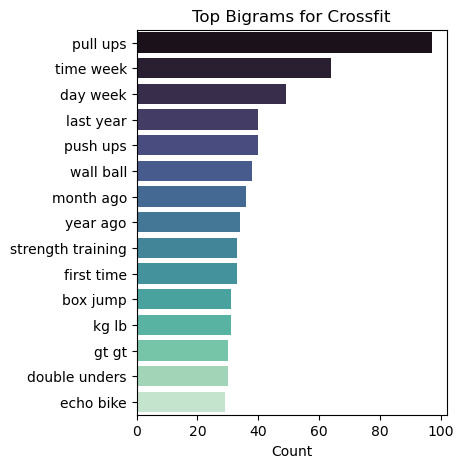

In [50]:
# Looking at the top bigrams by count

counts2[['total_count']].sort_values(by = 'total_count', ascending = False)
top_words = counts2[['total_count']].sort_values(by = 'total_count', ascending = False).head(15)
fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(top_words, y = top_words.index, x = 'total_count', palette="mako").set(title='Top Bigrams for Crossfit')
ax.set_xlabel('Count')

Unlike the unigrams which were much more general, the bigrams present a stronger flavour of Crossfit, with common workout exercises (pull ups, box jumps, double unders) and equipment (echo bike, wall ball) listed as some of the top mentions.

#### BJJ top occuring words

In [51]:
# Total number of words in the corpus

total_words = 0

for text in bjj_clean['lemmatized']:
    words = text.split()
    total_words += len(words)
print(total_words)

65583


46.120253164556964


/var/folders/r9/9246nqp9249ghjl6r9xy_dwr0000gn/T/ipykernel_7665/936614521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bjj_clean["length"] = bjj_clean["lemmatized"].apply(lambda x : len(x.split()))


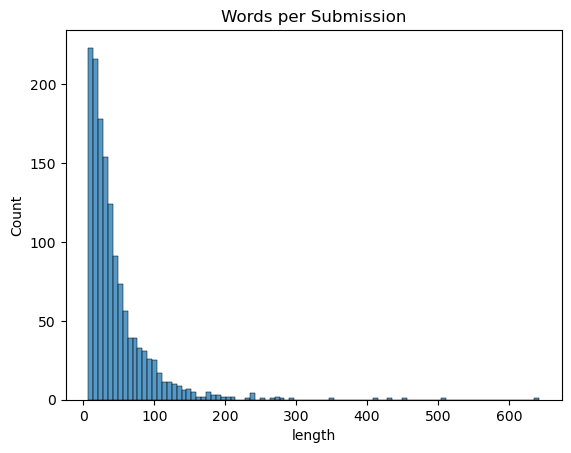

In [52]:
# Length of each submission

bjj_clean["length"] = bjj_clean["lemmatized"].apply(lambda x : len(x.split()))
sns.histplot(bjj_clean["length"]).set(title='Words per Submission')
print(bjj_clean["length"].mean())

In [53]:
# Counting unigrams

cv = CountVectorizer(ngram_range=(1,1))

In [54]:
# Tokenenising cv = CountVectorizer()

X = cv.fit_transform(bjj_clean['lemmatized'])
X_df = X.toarray()

In [55]:
# Obtaining the bag of words 

counts = pd.DataFrame(X_df, columns = cv.get_feature_names_out())

In [56]:
# Getting the words 

words = cv.get_feature_names_out()
len(words)

7857

In [57]:
counts2 = counts.T.sort_values(by=0, ascending=False)
counts2['total_count'] = counts2.sum(axis = 1)
counts2.T

,level,brown,highly,quite,recommendation,northern,disappointing,name,shame,liverpool,...,flexion,flexing,flexible,flexibility,flexed,flex,flew,flesh,fledgling,zoom
0,2,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Count')

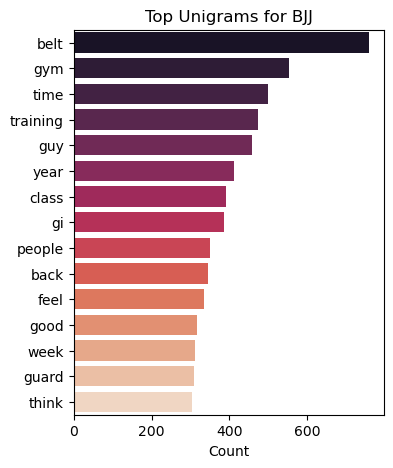

In [58]:
# Looking at the top unigrams by count

counts2[['total_count']].sort_values(by = 'total_count', ascending = False)
top_words = counts2[['total_count']].sort_values(by = 'total_count', ascending = False).head(15)
fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(top_words, y = top_words.index, x = 'total_count', palette="rocket").set(title='Top Unigrams for BJJ')
ax.set_xlabel('Count')

In [59]:
# Counting bigrams

cv = CountVectorizer(ngram_range=(2,2))

In [60]:
# Tokenenising cv = CountVectorizer()

X = cv.fit_transform(bjj_clean['lemmatized'])
X_df = X.toarray()


In [61]:
# Getting the words 

counts = pd.DataFrame(X_df, columns = cv.get_feature_names_out())
words = cv.get_feature_names_out()

In [62]:
# getting total counts of each 

counts2 = counts.T.sort_values(by=0, ascending=False)
counts2['total_count'] = counts2.sum(axis = 1)

Text(0.5, 0, 'Count')

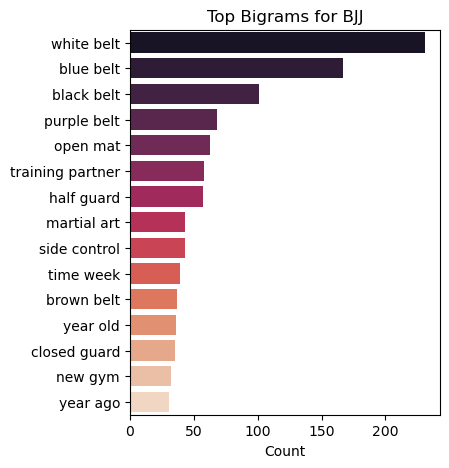

In [63]:
# Looking at the top bigrams by count

counts2[['total_count']].sort_values(by = 'total_count', ascending = False)
top_words = counts2[['total_count']].sort_values(by = 'total_count', ascending = False).head(15)
fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(top_words, y = top_words.index, x = 'total_count', palette="rocket").set(title='Top Bigrams for BJJ')
ax.set_xlabel('Count')

The bigrams for BJJ are very closely associated with the belt system and techniques, and clearly differentiated from Crossfit.
Given that both sports appear quite dissimilar based on the EDA so far, the classifier is expected to achieve a high accuracy rate since the top words are quite distinct. The main drawback can be referenced from the commonalities in unigrams: doing well in both sports usually involves consistent training in the gym. Posts about this topic could be easily misclassified.

#### Overall dataset general EDA

In [64]:
# After cleaning, looking again at total number of submissions from both subreddits

df.groupby('label')["lemmatized"].count()

label
bjj         1422
crossfit    1366
Name: lemmatized, dtype: int64

Classes are quite evenly distributed at 49% for Crossfit and 51% for BJJ. 

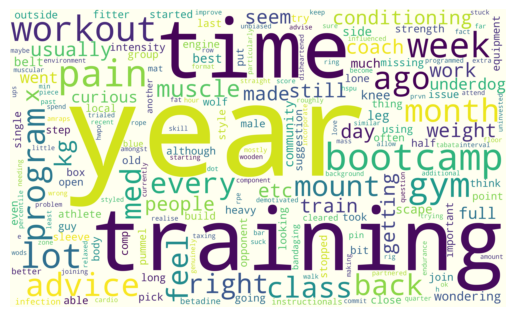

In [65]:
# Creating a word cloud to check if other keywords should be removed for better modeling

text = df['lemmatized']

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1000,height=600,background_color='ivory',scale=4).generate(str(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.show()

The word cloud this time has fewer single alphabets, which are not interpretable in a model. The theme of time comes out a little more strongly with words like "year" and "week", as well as the themes of medicine and pain which may be related to injuries and soreness.

### Topic Modeling

Latent Dirichlet Allocation (LDA) is an unsupervised clustering technique used for topic modelling. We can try it out to see which topics might be associated with the text, and which keywords are associated with them.

In [66]:
# Creating function for LDA

def build_lda(text, num_of_topic=5):
    vec = CountVectorizer()
    transformed_text = vec.fit_transform(text)
    feature_names = vec.get_feature_names_out()
    lda = LatentDirichletAllocation(n_components=num_of_topic, 
                                    max_iter=5,
                                    learning_method='online', 
                                    random_state=8)
    lda.fit(transformed_text)
    return lda, vec, feature_names


In [67]:
def display_word_distribution(model, feature_names, n_word):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-n_word - 1:-1]:
            words.append(feature_names[i])
        print(words)
        
lda_model, vec, feature_names = build_lda(crossfit_clean['lemmatized'])

display_word_distribution(model=lda_model, 
                          feature_names=feature_names,
                          n_word=5)

Topic 0:
['gym', 'workout', 'time', 'year', 'week']
Topic 1:
['drink', 'de', 'car', 'en', 'brand']
Topic 2:
['ups', 'pull', 'lb', 'squat', 'rep']
Topic 3:
['gt', 'team', 'double', 'worm', 'unders']
Topic 4:
['body', 'calorie', 'cell', 'protein', 'disorder']


<br>
This quick attempt at deriving topics based on clustering of unigrams provided some insight on potential topics that people passionate about Crossfit may post on Reddit:

- **Topic 0: Scheduling workouts.** Might be comments relating to how challenging it is to be disciplined about training amidst a busy schedule. 
- **Topic 2 and 3: Equipment and weights.** Some common Crossfit moves include kipping pull ups, squats which are done for as many reps and as heavy as possible. 'lb' or pounds is the unit used in the US for amount of weight pushed. A 'worm' is a long bag that is filled with sand using for team strength training. 
- **Topic 4: Diet and calorie counting:** Protein is a must-have for muscle recovery among many athletes, and some pay attention to much calories they're consuming per week. It may also be relating to eating disorders. 

In [68]:
def display_word_distribution(model, feature_names, n_word):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-n_word - 1:-1]:
            words.append(feature_names[i])
        print(words)
        
lda_model, vec, feature_names = build_lda(bjj_clean['lemmatized'])

display_word_distribution(model=lda_model, 
                          feature_names=feature_names,
                          n_word=5)

Topic 0:
['gordon', 'adcc', 'ryan', 'use', 'nicky']
Topic 1:
['belt', 'gym', 'guy', 'time', 'gi']
Topic 2:
['pant', 'fitted', 'course', 'category', 'buy']
Topic 3:
['belt', 'time', 'side', 'leg', 'control']
Topic 4:
['wash', 'bandaging', 'betadine', 'cleared', 'right']


<br>

And for BJJ: 

- **Topic 0: Top competitive practitioners.** Gordon Ryan is an American submission grappler considered by many to be the greatest no–gi grappler of all time due to his accomplishments. ADCC refers to Abu Dhabi Combat Club, likely the competition they organise "Submission Fighting World Championship", also known as the Olympics of grappling.
- **Topic 1: BJJ uniform.** The gi is the training uniform for BJJ, and it also comes along with a belt using to signify rank. 
- **Topic 3: Techniques** One of the 6 main positions in BJJ, "side control" is a pinning position in when one person is perpendicular to their opponent and not entangled in their legs.
- **Topic 4: Injuries and remedies.** Cuts or mat burns might be common in close contact martial arts and grappling. Bandages and Betadine are dressing and antibacterial ointment that help with this.


For a more comprehensive attempt at topic modelling, we can try using Word2Vec to see if we can generate more detailed topics.

In [69]:
# Fitting a Word2Vec model to look at words by their similarity and dissimilarity

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
print(w2v_model)

Word2Vec(vocab=0, size=300, alpha=0.03)


In [70]:
w2v_model.build_vocab(df['lemmatized'])
print(w2v_model)

Word2Vec(vocab=28, size=300, alpha=0.03)


In [71]:
# Fit model with CBOW method over 5 epochs

w2v_model.train(df['lemmatized'], 
                total_examples=w2v_model.corpus_count, 
                epochs=5)

(155704, 4093465)

In [72]:
# Creating phrases and bigrams

sent = [row.split() for row in df['lemmatized']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [73]:
# Word frequencies

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)


11129

In [74]:
# Top 25 words by frequency

sorted(word_freq, key=word_freq.get, reverse=True)[:25]

['gym',
 'time',
 'year',
 'training',
 'people',
 'back',
 'class',
 'feel',
 'good',
 'guy',
 'day',
 'week',
 'workout',
 'think',
 'work',
 'going',
 'month',
 'much',
 'weight',
 'new',
 'way',
 'even',
 'gi',
 'looking',
 'first']

In [75]:
# Fitting the model

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [76]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [77]:
# Training the model

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(861022, 3658140)

In [78]:
w2v_model.init_sims(replace=True)

In [79]:
# Finding the words most similar to "training"

training_word = w2v_model.wv.most_similar(positive=["training"])
training_word

[('month', 0.9994494318962097),
 ('schedule', 0.9994399547576904),
 ('compete', 0.9993502497673035),
 ('local', 0.9992703795433044),
 ('competition', 0.999255359172821),
 ('group', 0.9991886019706726),
 ('trained', 0.9991737604141235),
 ('current', 0.999160885810852),
 ('joining', 0.9991261959075928),
 ('fun', 0.9991248846054077)]

"Training" is a word associated with structure, time scheduling and competition.

In [80]:
# Finding the words most similar to "protein"

w2v_model.wv.most_similar(positive=["protein"])

[('g', 0.9973487854003906),
 ('calorie', 0.9971998929977417),
 ('macro', 0.9922809600830078),
 ('fat', 0.9900269508361816),
 ('meal', 0.9887982606887817),
 ('total', 0.9884976148605347),
 ('air', 0.9874547719955444),
 ('eat', 0.9868654012680054),
 ('day', 0.9867475032806396),
 ('daily', 0.9866331219673157)]

"Protein" commonly occurs with words like fat, calorie, meal and macro, which are all diet-related terms common used by athletes who pay attention to meal planning and sticking to a healthy lifestyle by adopting a low-fat diet and counting their calories.

In [81]:
# Similarity between 2 words

w2v_model.wv.similarity("train", 'time')

0.9944117

In [82]:
# Finding the odd one out

w2v_model.wv.doesnt_match(['double', 'pull', 'gi'])

/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'gi'

In [83]:
#  Visualising the word vectors

def tsnescatterplot(model, word, list_names):
    
    """ 
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 15 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


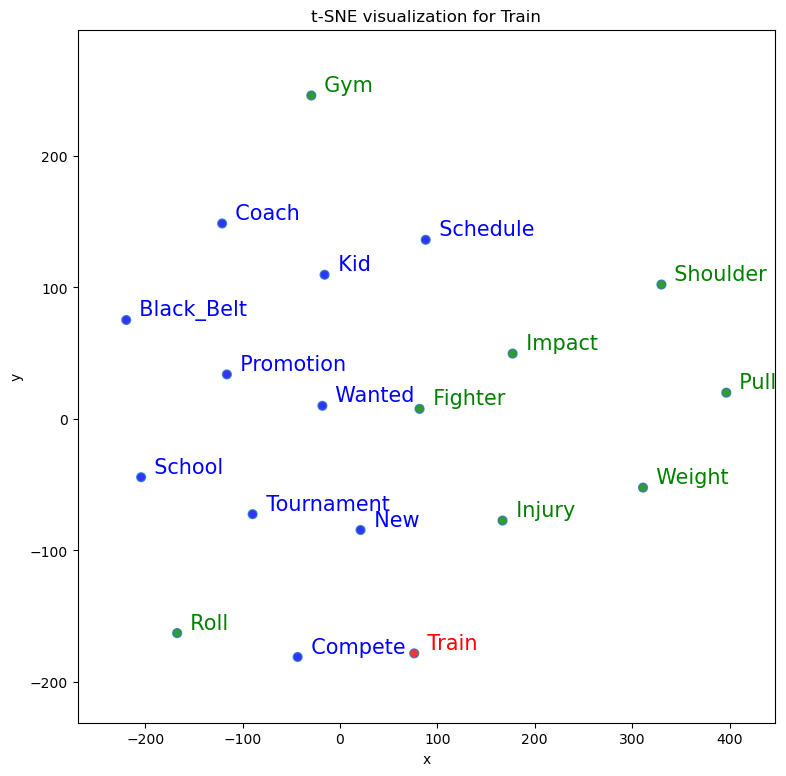

In [84]:
# Visualising the words most similar to 'train' and 8 other random ones

tsnescatterplot(w2v_model, 'train', ['gym', 'shoulder', 'impact', 'injury', 'roll', 'pull', 'weight', 'fighter'])

### 4. Prepping the training and test data sets

Now we move on to prep the necessary datasets for training, validation and testing.

In [85]:
# Looking at the different subsets to get an idea of distribution by classes

df.groupby('label')['lemmatized'].count()

label
bjj         1422
crossfit    1366
Name: lemmatized, dtype: int64

In [86]:
bjj = df[df['label'] == 'bjj']
crossfit = df[df['label'] == 'crossfit']

In [87]:
# Splitting bjj data into training and hold-out sets 

x, x_test, y, y_test = train_test_split(bjj['lemmatized'], bjj['label'], test_size=0.2, random_state=42)

In [88]:
# Hold-out set

bjj_hold_out_x = pd.DataFrame(x_test)
bjj_hold_out_y = pd.DataFrame(y_test)

print('Length of BJJ hold-out set: ', len(bjj_hold_out_x))

Length of BJJ hold-out set:  285


In [89]:
# Training/validation set

bjj_train_x = pd.DataFrame(x)
bjj_train_y = pd.DataFrame(y)

print('Length of BJJ training set: ', len(bjj_train_x))

Length of BJJ training set:  1137


In [90]:
# Splitting crossfit data into training and hold-out sets 

x2, x_test2, y2, y_test2 = train_test_split(crossfit['lemmatized'], crossfit['label'], test_size=0.2, random_state=42)

In [91]:
# Hold-out set

crossfit_hold_out_x = pd.DataFrame(x_test2)
crossfit_hold_out_y = pd.DataFrame(y_test2)

print('Length of Crossfit hold-out set: ', len(crossfit_hold_out_x))

Length of Crossfit hold-out set:  274


In [92]:
# Training/validation set

crossfit_train_x = pd.DataFrame(x2)
crossfit_train_y = pd.DataFrame(y2)

print('Length of Crossfit training set: ', len(crossfit_train_x))

Length of Crossfit training set:  1092


In [93]:
# Combining again for training set 

bjj_train = pd.concat([bjj_train_x,bjj_train_y], axis = 1).reset_index()
crossfit_train = pd.concat([crossfit_train_x,crossfit_train_y], axis = 1).reset_index()


In [94]:
bjj_train.head()

,index,lemmatized,label
0,1149,game beginning far time dedication point year training recently started training high level black belt guy squeeze ever felt discouraging much inspiring lack better word obtain type squeeze soon mount try use technique head arm fight breathes squeeze dominates technique strength guy straight brazil definitely advantageous genetics dna Brazil,bjj
1,688,let u face fighter tough good boxing rather let fighter sustain damage alter career prevent leading comfortable life ref call tko end fight tko watch limb destroyed watch match family come view poll,bjj
2,222,standard practice always given quite bit leeway student especially come asking clean return class say need cancel membership entirely due affording given month free discounted rate without batting eye good partner rather train especially passionate training brown belt however major problem past year canceled membership said going open school back week later never signed back keep promising bring cash make mind first brown belt gone pretty far stolen drink cooler foam roller rash guard school shirt month membership add total yesterday open mat tap training go getting black belt bitch kind ticked told tradition asshole give blackbelt someone support gym need square give shit pouted stormed suggestion deal guy,bjj
3,348,hey moving plovdiv bulgaria saw school located lucas lepri victory raider thrace experience school give recommendation gi nogi training good atmosphere comeptitiv spirit need translator necessarily,bjj
4,1227,partner gym old gym become pretty obvious last grading people getting graded differently come beginner fundamental class compete getting stripe sometimes faster come advanced class compete stripe group student come time week come time week always seems beginner hobbyist graded faster heard coach say privately higher belt grade people beginner hobbyist faster progress beginner class advanced class compete win wanted common thing gym separate hobbyist competitor grading progressing people differently depending compete common post taking account gym favourite whole different thing,bjj


In [95]:
crossfit_train.head()

,index,lemmatized,label
0,1340,much harder ttb time curled body far enough k e contact foot least inch bar probably ankle lower shin made contact struggled string together proper kip uncurl body first whole rhythm wrong contrary many female longer torso rex arm leg,crossfit
1,1408,form exercise always mainly running outside recently interested dabbled machine dumbbell experience lifting weight using proper form signing local gym wondering thing beginner thing told compete others take everything slow advice,crossfit
2,1357,forgive sounding silly f rarely doctor life except annual checkup past month knee paining gotten point nearly tear today warmup run kettlebell squat stretching modified workout accordingly even tough rowing favored knee noticed running squat bother active whole life begun recently pain kneecap almost feel bone thing v tendon injury life sure longer ignore regular doc pt tia,crossfit
3,936,currently monday wednesday friday started august year consequently lifting huge weight usually female rx weight male rx body weight movement usually feel pretty sore day heat pad massage gun beneficial stretching hydrating suffice admit stretch hydrate much advance,crossfit
4,61,disclaimer answer opinion medical professional health insurance medical intervention necessary paying x ray tell take easy amp rest noticed month ago pretty significant soreness tibia halfway inside shin started workout lot toe bar amp box jump though pain mostly felt hop rig pain initially fairly tolerable though pain gotten quite bit worse admittedly missed workout favor right leg impact movement pain mostly felt jump hop rig trying practice dub every day point morning could hardly use left leg research look stress fracture tibia relatively common amongst athlete particularly inside lower third amp x b assume imagine heal within week rest take time lose progress pretty much thing avoid significant injury getting worse actually breaking bone completely sure possible likely amp x b curious thought regarding continuing exercise caution ie replace running dub etc bike box jump air squat ttb v ups honest thought feedback,crossfit


In [96]:
# obtaining the full training data set

train = pd.concat([bjj_train,crossfit_train], axis = 0)
train.reset_index(inplace=True)
print('Length of complete training set: ', len(train))

Length of complete training set:  2229


In [97]:
# obtaining the full holdout data set

holdout_x = pd.concat([bjj_hold_out_x, crossfit_hold_out_x], axis = 0)
print('Length of holdout set: ', len(holdout_x))

Length of holdout set:  559


In [98]:
# obtaining the full holdout data set (actual y-values) to check back on the predicted results

holdout_y = pd.concat([bjj_hold_out_y,crossfit_hold_out_y], axis = 0)
print('Length of holdout set: ', len(holdout_y))

Length of holdout set:  559


In [99]:
# Saving as csv

train.to_csv('../data/mma2.csv')
holdout_x.to_csv('../data/holdout_x.csv')
holdout_y.to_csv('../data/holdout_y.csv')